In [ ]:
#Installing Scanpy along with other Single Cell dependencies
%pip install numpy anndata scanpy[skmisc] igraph leidenalg umap-learn muon plotnine harmonypy pydeseq2 pymemesuite pyjaspar pyupset gprofiler-official psutil pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.7/293.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 114.6 MB/s eta 0:00:00
   ━

In [ ]:
#Libraries for downloading/manipulating data
import os, gc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt

# Core scverse libraries
import anndata as ad
import scanpy as sc

import seaborn as sns
from scipy.stats import median_abs_deviation

#plotting
from plotnine import (
    ggplot,
    aes,
    scale_x_log10,
    scale_y_log10,
    geom_point,
    geom_violin,
    geom_boxplot,
    geom_jitter,
    theme_matplotlib,
    theme_set,
)
from gprofiler import GProfiler
from pyjaspar import jaspardb
import Bio
from typing import List

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from scipy.sparse import diags

# Data retrieval
import pooch
from muon import atac as ac

#Libraries for XGBoost implementation
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.preprocessing import LabelEncoder

#RAM-CPU profiling
import psutil
import threading
import pynvml

<h2>Part 0: Downloading the dataset and RAM/CPU measuring function</h2>



In [ ]:
def download_dataset():
  """
  Download and load the single-cell RNA sequencing dataset as an AnnData object.

    Here, a dataset is downloaded from a certain URL, consequetively the dataset is loaded into an AnnData object.
    Input: !wget -c downloadLink -O sameNameAsFile.h5ad
    Returns: adata (AnnData file)
  """
  #!wget -c https://datasets.cellxgene.cziscience.com/cd6c6c36-d483-4025-8840-9d0b766c40ee.h5ad  -O mouse_ependymal_6K.h5ad
  #adata = ad.read_h5ad("mouse_ependymal_6K.h5ad")
  !wget -c https://datasets.cellxgene.cziscience.com/f4b594d9-1c81-420d-9cac-d9cb7041c921.h5ad  -O human_gland_50k.h5ad
  adata = ad.read_h5ad("human_gland_50k.h5ad")

  return adata
adata = download_dataset()

--2025-03-11 11:20:05--  https://datasets.cellxgene.cziscience.com/f4b594d9-1c81-420d-9cac-d9cb7041c921.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 99.86.38.61, 99.86.38.115, 99.86.38.71, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|99.86.38.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257546770 (246M) [binary/octet-stream]
Saving to: ‘human_gland_50k.h5ad’

human_gland_50k.h5a 100%[===================>] 245.62M  16.1MB/s    in 15s     

2025-03-11 11:20:21 (16.3 MB/s) - ‘human_gland_50k.h5ad’ saved [257546770/257546770]



In [ ]:
#RAM-GPU-CPU profiling
pynvml.nvmlInit()

def GPU_measures():
  """
  Measures the current usage of GPU
  Input: None
  Output: GPU memory usage in Mb
  """
  handle = pynvml.nvmlDeviceGetHandleByIndex(0) #Selects any GPU available
  gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(handle) #Gets the use percentage of the GPU
  gpu_perc = gpu_usage.gpu

  return gpu_perc

training = True #Boolean required for threading the RAM/CPU process
ram_usage, cpu_usage, gpu_usage = [],[],[]

def RAM_CPU_GPU_measures():
  """
  Measures the current use of RAM and CPU every second and stores them in their respective arrays
  Input: None
T  Output: RAM, CPU and GPU usage arrays
  """
  while training:
    time.sleep(1)
    ram_usage.append(psutil.virtual_memory().percent)
    cpu_usage.append(psutil.cpu_percent())
    gpu_usage.append(GPU_measures())


<h2>Part 1: Data preprocessing</h2>

In [ ]:
def preprocessing(adata,min_genes,min_cells,max_perc,min_perc,cut_2k):
  """
  Performs a rutinary (low-expressed genes, outlier removal, normalization and log transformation)
  pre-processing assay to the input data

  Input: AnnData file, minimum of expressing genes, minimum of expressing cells, maximum and minimum quantiles, and
  boolean if only the most variable genes are wanted
  Output: AnnData file with preprocessed data
  """
  prev_dims = adata.shape
  sc.pp.filter_cells(adata, min_genes=min_genes) #Eliminate cells that do not express at least min_genes
  sc.pp.filter_genes(adata, min_cells=min_cells) #Delete genes that are not expressed in at least min_cells

  #Required for quantile calculations
  adata.var["mt"] = adata.var_names.str.startswith("MT-") #Creates an additional column with the variable "MT" (to see if the gene is mitochondrial or not upfront)
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], log1p=False, inplace=True) #Calculates metrics

  #Quantile calculations
  up_lim = np.quantile(adata.obs.n_genes_by_counts.values, max_perc)
  low_lim = np.quantile(adata.obs.n_genes_by_counts.values,min_perc)
  adata = adata[(adata.obs.n_genes_by_counts < up_lim) & (adata.obs.n_genes_by_counts > low_lim)] #Deletes genes outside of the quantile range

  #Normalizing and log transforming data
  sc.pp.normalize_total(adata, target_sum = 1e4) #1e4: Normalization standard
  sc.pp.log1p(adata)

  #Taking the n_top_genes most variable genes only
  if cut_2k == True:
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
    adata = adata[:,adata.var["highly_variable"]]

  new_dims = adata.shape
  print("Initial dims: {} \nDims after preprocessing: {}".format(prev_dims,new_dims))
  return adata

st = time.time()
adata = preprocessing(adata, min_genes = 200, min_cells = 3, max_perc = 0.95, min_perc = 0.05,cut_2k = False)
print("Preprocessing time: {:.2f} s".format(time.time()-st))

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.


Initial dims: (50240, 36306) 
Dims after preprocessing: (40385, 25969)
Preprocessing time: 27.001001596450806


<h2>Part 2: Gradient boosting using XGBoost</h2>

In [ ]:
X = adata.X #Input data to our model
#Encoding the labels (giving them a number between 0 and n_types-1)
enc = LabelEncoder()
enc.fit(adata.obs["cell_type"])
y = enc.transform(adata.obs["cell_type"])

#Splitting our data into training and testing (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42) #stratify=y: Fixes class inbalance of the y array (basic method for this)

#XGBoost implementation with time, memory and CPU metrics
st = time.time()

clas = xgb.XGBClassifier(objective = "multi:softmax", random_state = 42, eval_metric = "mlogloss", device = "cuda") #cuda enables GPU usage if available
threading.Thread(target = RAM_CPU_GPU_measures,daemon=True).start() #RAM/CPU measuring in real time
clas.fit(X_train,y_train)

training = False
print("Runtime: {:.3f} s".format(time.time()-st))

Runtime: 394.968 s


<h2>Part 3: Metrics and performance</h2>

In [ ]:
#Testing and analyzing the prediction
y_pred = clas.predict(X_test)

#Finding the confusion matrix, accuracy score and F1-score
import sklearn.metrics as skm
#Calculating our metrics
conf = skm.confusion_matrix(y_test,y_pred) #Confusion matrix
acc = skm.accuracy_score(y_test,y_pred) #Accuracy score
f1 = skm.f1_score(y_test,y_pred,average = "weighted") #F1-score

print("Confusion matrix:")
print(conf)
print("accuracy: {:.3f}".format(acc))
print("f1-score: {:.3f}".format(f1))

Confusion matrix:
[[   4    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2   87   35    0    6    0    0    0    0    0    0    0    0    0
     0    0    0    0    1]
 [   0   30  356    0    7    0    0    0    0    1    0    0    0    0
     0    4    1    0    0]
 [   0    0    1   95    2    0    0    0    0    0    0    2    0    0
     0    0    0    0    0]
 [   0    1    0    1 4237    0    2    0    0    1    3    1    0    1
     0    0    0    4   51]
 [   0    0    0    0    1    5    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    1    0    8    0  424    0    3    0    0    0    1    1
     0    0    0    0    1]
 [   0    1    0    0    3    0    0   30    0    0    0    0    9    0
     0    0   18    0    0]
 [   0    0    0    0    0    0    6    0    6    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0    0   13    0    1    0    0  717    0    0    0    0
     0    

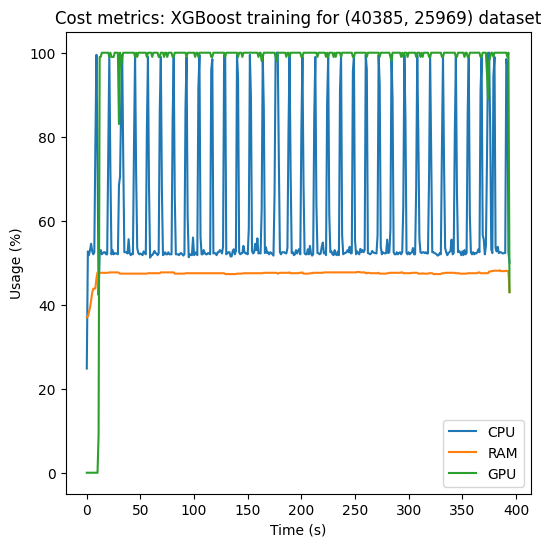

In [ ]:
plt.figure(figsize=(6,6))
plt.title("Cost metrics: XGBoost training for {} dataset".format(X.shape))
plt.plot(cpu_usage,label="CPU")
plt.plot(ram_usage,label="RAM")
plt.plot(gpu_usage,label="GPU")
plt.xlabel("Time (s)")
plt.ylabel("Usage (%)")
plt.legend()
plt.savefig("comp_metrics_{}x{}.png".format(X.shape[0],X.shape[1]),dpi = 300)

In [ ]:
#Storing all usage metrics in a .csv dataset
metrics = {"cpu":cpu_usage, "ram": ram_usage, "gpu": gpu_usage}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("comp_metrics_{}x{}.csv".format(X.shape[0],X.shape[1]))

<h2>Part 4: UMAP of the predicted data</h2>

In [ ]:
type(X_test)

scipy.sparse._csr.csr_matrix